In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os

cluster_number = []
for cluster_threshold in range(8, 14):
    dates = os.listdir("/media/ubuntu/sda/data/mouse6/output/sorting_natural_image_new")

    cluster_inf = pd.DataFrame()
    spike_inf = pd.DataFrame()
    waveform_mean = pd.DataFrame()

    for date in dates:
        cluster_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output/sorting_natural_image_new/{date}/output/cluster_inf.tsv', sep = '\t').iloc[:, 1:]
        cluster_inf_temp['date'] = date
        cluster_inf = pd.concat((cluster_inf, cluster_inf_temp), axis= 0)

        spike_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output/sorting_natural_image_new/{date}/output/spike_inf.tsv', sep = "\t").iloc[:, 1:]
        spike_inf_temp['date'] = date
        spike_inf = pd.concat((spike_inf, spike_inf_temp), axis=0)

        waveform_mean_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output/sorting_natural_image_new/{date}/output/waveform_mean.tsv', sep = "\t").iloc[:, 1:]
        waveform_mean_temp.columns = waveform_mean_temp.columns + f"_{date}"
        waveform_mean = pd.concat((waveform_mean, waveform_mean_temp), axis=1)


    del waveform_mean_temp, spike_inf_temp, cluster_inf_temp

    num = 8
    cluster_inf['Neuron'] = None
    cluster_inf.iloc[0, 27] = 1
    neuron_inf = pd.DataFrame(cluster_inf.iloc[0, :]).T
    neuron = 1
    for i in range(1, len(cluster_inf)):
        found = False
        for j in range(len(neuron_inf)):
            if (abs(cluster_inf.iloc[i, 22] - neuron_inf.iloc[j, 22]) <= num) and (abs(cluster_inf.iloc[i, 23] - neuron_inf.iloc[j, 23]) <= num):
                cluster_inf.iloc[i, 27] = neuron_inf.iloc[j, 27]
                found = True
                break
        if not found:
            neuron += 1
            cluster_inf.iloc[i,27] = neuron
            neuron_inf = pd.concat((neuron_inf, pd.DataFrame(cluster_inf.iloc[i, :]).T), axis=0)

    neurons_with_count_gt_16 = cluster_inf['Neuron'].value_counts()
    neuron_values = neurons_with_count_gt_16[neurons_with_count_gt_16 >= 13].index.tolist()

    num = 1
    neuron_cluster_dict = {}
    for neuron in neuron_values:
        temp = cluster_inf[cluster_inf['Neuron'] == neuron]
        filter_cluster = temp.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
        waveform_mean_temp = waveform_mean.loc[:, filter_cluster]

        from sklearn.cluster import DBSCAN
        from sklearn.decomposition import PCA


        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(waveform_mean_temp.T)

        eps = 100
        min_samples = 1

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(principal_components)

        #plt.Figure(figsize=(5, 5))
        #sns.scatterplot(x = principal_components[:, 0],
        #            y = principal_components[:, 1],
        #            hue=dbscan.labels_)
        #plt.title(neuron)
        #plt.show()

        filter_cluster = pd.DataFrame(filter_cluster).reset_index(drop=True)
        filter_cluster = pd.concat((pd.DataFrame(filter_cluster), pd.DataFrame(dbscan.labels_)), axis=1)
        filter_cluster.columns = ['cluster_date', 'dbscan_labels']
        for i in filter_cluster['dbscan_labels'].value_counts().index:
            neuron_cluster_dict[f'Neuron_{num}'] = filter_cluster.loc[filter_cluster['dbscan_labels'] == i, 'cluster_date'].tolist()
            num += 1

    neuron_cluster_dict = {key: value for key, value in neuron_cluster_dict.items() if len(value) >= cluster_threshold}
    cluster_number.append(len(neuron_cluster_dict.keys()))
    print(f'Neuron numbers: {len(neuron_cluster_dict.keys())}')

Neuron numbers: 36
Neuron numbers: 34
Neuron numbers: 31
Neuron numbers: 31
Neuron numbers: 29
Neuron numbers: 26


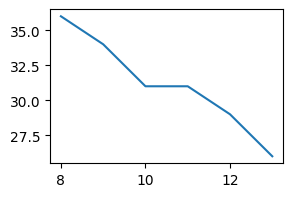

In [5]:
plt.figure(figsize=(3,2))
sns.lineplot(x = range(8, 14),
             y = cluster_number)
plt.show()